<a href="https://colab.research.google.com/github/Meddebma/pyradiomics/blob/master/3D_Segmentation_eval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Setup environment**

In [ ]:
#%pip uninstall monai--weekly
%pip install monai
%pip install 'monai[nibabel, skimage, pillow, tensorboard, gdown, ignite, torchvision, itk, tqdm, lmdb, psutil]'
%pip install matplotlib
#%pip install -q pytorch-lightning
%pip install pytorch-lightning
%matplotlib inline

In [ ]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

from monai.utils import set_determinism
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    ScaleIntensityRanged,
    Spacingd,
    LabelToContour,
    KeepLargestConnectedComponent,
    ToTensord,
)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import compute_meandice, compute_roc_auc
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, list_data_collate
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import pytorch_lightning
from pytorch_lightning.callbacks.model_checkpoint \
    import ModelCheckpoint
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import sys
from glob import glob
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import pandas as pd
import seaborn as sns 



print_config()

calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
`pytorch_lightning.metrics.*` module has been renamed to `torchmetrics.*` and split off to its own package (https://github.com/PyTorchLightning/metrics) since v1.3 and will be removed in v1.5
pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.


MONAI version: 0.5.3
Numpy version: 1.19.5
Pytorch version: 1.9.0+cu102
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: d78c669c67e38ddfbe572f6a0438e9df0b8c65d7

Optional dependencies:
Pytorch Ignite version: 0.4.4
Nibabel version: 3.0.2
scikit-image version: 0.16.2
Pillow version: 7.1.2
Tensorboard version: 2.4.1
gdown version: 3.6.4
TorchVision version: 0.10.0+cu102
ITK version: 5.1.2
tqdm version: 4.61.1
lmdb version: 0.99
psutil version: 5.4.8

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [ ]:
ima_dir= "/content/drive/My Drive/Spleen_AI/Projekt2ß"

images = sorted(glob(os.path.join(ima_dir, "*.nii.gz")))
labels = sorted(glob(os.path.join(ima_dir, "*.nii.gz")))

test = [{"image": image_name, "label": label_name}
            for image_name, label_name in zip(images, labels)]
val_transforms = Compose(
            [
                LoadImaged(keys=["image", "label"]),
                AddChanneld(keys=["image", "label"]),
                Spacingd(
                    keys=["image", "label"],
                    pixdim=(1.5, 1.5, 2.0),
                    mode=("bilinear", "nearest"),
                ),
                Orientationd(keys=["image", "label"], axcodes="PLI"),
                ScaleIntensityRanged(
                    keys=["image"], a_min=-57, a_max=164,
                    b_min=0.0, b_max=1.0, clip=True,
                ),
                CropForegroundd(keys=["image", "label"], source_key="image"),
                ToTensord(keys=["image", "label"]),
            ]
        ) 
val_ds = CacheDataset(
            data=test, transform=val_transforms,
            cache_rate=1.0, num_workers=2,
        )
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=1, num_workers=2)
from monai.metrics import DiceMetric
from monai.transforms import Activations, AddChannel, AsDiscrete, Compose, ScaleIntensity, ToTensor
dice_metric = DiceMetric(include_background=True, reduction="mean")
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold_values=True), KeepLargestConnectedComponent(applied_labels=[1])])


Loading dataset: 100%|██████████| 6/6 [00:16<00:00,  2.78s/it]


val_dice: tensor([[nan]], device='cuda:0')
Hausdorff: tensor([[251.8432]], dtype=torch.float64)
Shape: torch.Size([1, 1, 252, 276, 246])
Volume: [tensor(67896, device='cuda:0')] mm3


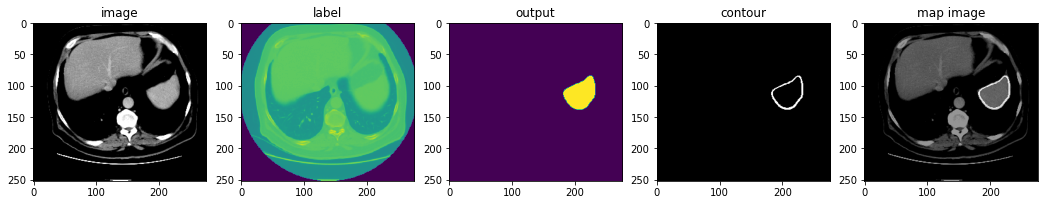

TypeError: ignored

In [ ]:
from monai.metrics import get_confusion_matrix, compute_hausdorff_distance
from monai.data import NiftiSaver
device = torch.device("cuda:0")
model =     UNet(
            dimensions=3,
            in_channels=1,
            out_channels=2,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2,
            ).to(device)
#loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
device = torch.device("cuda:0")
model.load_state_dict(torch.load("/content/drive/My Drive/Spleen_AI/best_metric_model_ch_500.pth"))
model.eval()
model.to(device)
with torch.no_grad():
        metric_sum = 0.0
        metric_count = 0
        saver = NiftiSaver(output_dir="/content/drive/My Drive/Spleen_AI/Projekt2ß/Segmentation")
        for val_data in val_loader:
            # define sliding window size and batch size for windows inference
            val_images, val_labels = val_data["image"].to(device), val_data["label"].to(device)
            roi_size = (96, 96, 96)
            sw_batch_size = 4
            val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model)
            val_outputs = post_trans(val_outputs)
            shape=val_images.shape
            vols = [(b[:,1]==1).sum() for b in val_outputs]
            value = compute_meandice(
            y_pred=val_outputs,
            y=val_labels,
            include_background=False)
          
            conf = get_confusion_matrix(y_pred=val_outputs, y=val_labels, include_background=False)
            hausdorff = compute_hausdorff_distance(y_pred=val_outputs, y=val_labels, include_background=False)
            metric_count += len(value)
            metric_sum += value.item() * len(value)
            #print(f"val_loss:", loss)
            print(f"val_dice:", value)
            #print(f"Confusion Matrix:", conf)
            print(f"Hausdorff:",hausdorff)
            print(f"Shape:", shape)
            print(f"Volume:", vols, f"mm3")
            #print(f"y_pred:",val_outputs)
            #print(f"y:", val_labels)
            
            plt.figure("check", (18, 6))
            plt.subplot(1, 5, 1)
            plt.title(f"image")
            plt.imshow(val_data["image"][0, 0, :, :, 25], cmap="gray")
            plt.subplot(1, 5, 2)
            plt.title(f"label")
            plt.imshow(val_data["label"][0, 0, :, :, 25])
            plt.subplot(1, 5, 3)
            plt.title(f"output")
            plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 25])
            plt.subplot(1, 5, 4)
            plt.title(f"contour")
            argmax = AsDiscrete(argmax=True)(val_outputs)
            largest = KeepLargestConnectedComponent(applied_labels=[1])(argmax)
            contour = LabelToContour()(largest) 
            plt.imshow(contour.detach().cpu()[0, 0, :, :, 25],cmap="gray")
            plt.subplot(1, 5, 5)
            plt.title(f"map image")
            map_image = contour + val_images
            plt.imshow(map_image.detach().cpu()[0, 0, :, :, 25], cmap="gray")
            plt.show()
            saver.save(val_outputs, meta_data="filename_or_obj")
        metric = metric_sum / metric_count
        print("evaluation metric:", metric)